Colab Address : https://colab.research.google.com/drive/1TmUUVuTEscmGnkPB8gGnunaLOlXOYxBK?usp=sharing

# Objective and Summary

Forecasts bring visibility to companies and it is common to use forecast to make estimations about the next day or month. The issue is that forecast will not change instantly at the moment the market behavior changes. We will need to wait for the next day or month. Some forecast tools will take multiple days or month to understand this is a market behavior change and not an outliers. 

To reduce the negative side, it is possible to use live data to forecast the end of day results? This is the question that I will try to answer in this paper.

3 models have been taken into account : ARIMA, LTSM ( neural network) and Facebook Prophet. Prophet has outperformed its peers in ease, cost, speed and accuracy.

**Important note : This needed to be ran on Colab because Prophet has high requirements in RAM and crashes 16go RAM MacBook Pro. Colab free tier up to provides 25 GB of RAM and disk space of 358.27 GB**



# Why Facebook Prophet.

Tree main types of models have been used to solve to create predictions:
* (S)ARIMA
* CNN-LSTM and ConvLSTM
* Facebook Prophet

Prophet has outperformed the other options by simplicity, running cost and accuracy. SARIMA, using the auto_fit model ended up very costly and slow making difficult the repeated fit that our predictions need.

LSTM, one type of deeplearning, has proven to be complex to set up, slower than Facebook ( although faster than SARIMA) and very innacurate. This is in line with the litterature about using LSTM for times-series prediction. Makridakis Competitions have shown that pure ML model are lagging in performance behind statistical models. Francois Chollet in his book "deep learning with python" has underlined that "many complex neural net architecture find it hard to beat simple baseline like averaging from same time period in the past." 

While there is potentially ways to improve the current LSTM model created, given the litterature and findings, the option does not seem to stack the odds in our favour.

Prophet is a statistical Model with the following components:

y(t) = g(t) + s(t) + h(t) + ϵ

* g(t) models trend, which describes long-term increase or decrease in the data. Prophet incorporates two trend models, a saturating growth model and a piecewise linear model, depending on the type of forecasting problem.
* s(t) models seasonality with Fourier series, which describes how data is affected by seasonal factors such as the time of the year (e.g. more searches for eggnog during the winter holidays)
* h(t) models the effects of holidays or large events that impact business time series (e.g. new product launch, Black Friday, Superbowl, etc.) Holiday is not used in this paper.

* ϵ represents an irreducible error term




# Next Steps

Prophet seems to not adapt well to changes. When rolling the prediction we expect the model to take into account the most recent data and there seems to be room for improvement. One further step is considering an additional layer of optimisation to improve the results.

# Set Environment

In [53]:
import pandas as pd
#load and plot dataset
from pandas import read_csv
from pandas import datetime
#from matplotlib import pyplot
from matplotlib import pyplot as plt

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))

import logging

from fbprophet import Prophet
logging.getLogger('fbprophet').setLevel(logging.WARNING)


from datetime import datetime
import datetime


# Set Number of weeks of training
**It takes about 1 second per additional week of training**

In [54]:
weeks = 4 # number of weeks to train
train_length = 24*7*weeks
print('total hourly training time is ' +str(train_length)+' hours')

total hourly training time is 672 hours


# Load data

We will use energy data fron the american electric power company. It is hourly data that has been cleaned before the test. Note: Facebook Prophet is said to be able to handle missing data very well). 

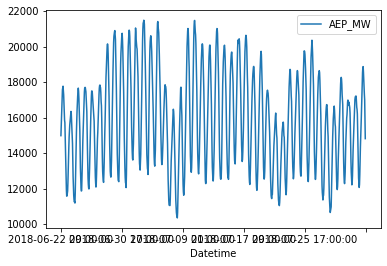

In [55]:
df2_url = 'https://raw.githubusercontent.com/charlesdethibault/my-library/master/datasets/american_electric_power_hourly_clean.csv'
df2 = pd.read_csv(df2_url)
series = df2[['Datetime','AEP_MW']].set_index('Datetime')
# cut data length
series = series.tail(1000)
series.plot()
plt.show()
# extract date to have it as column
series['ds']= series.index
series['ds'] = pd.to_datetime(series['ds'])
# reset index
series = series.reset_index(drop=True)
# rename columns to match prophet requirements
series.columns = ['y','ds']

# Prophet Analysis

In [0]:
train, test = series[0:train_length], series[train_length:len(series)]

m = Prophet(changepoint_prior_scale=1, daily_seasonality=True,weekly_seasonality=True).fit(train)
future = m.make_future_dataframe(periods=24, freq='H')
forecast = m.predict(future)

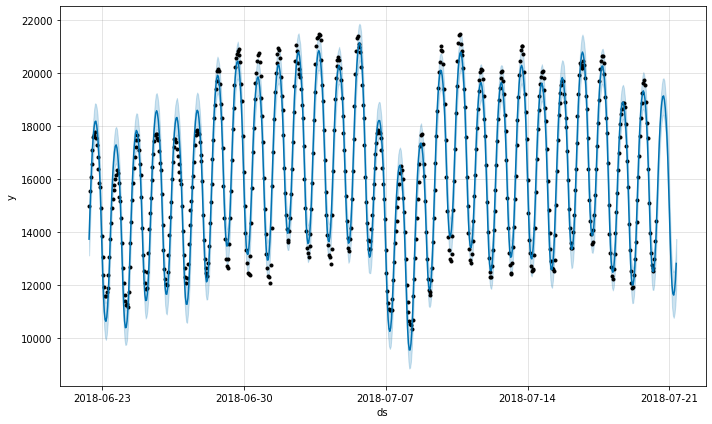

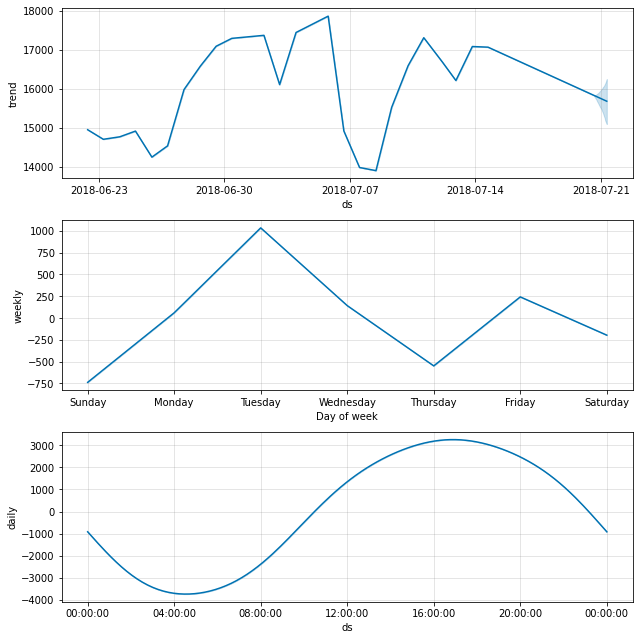

In [57]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
fig = m.plot_components(forecast)


## Changepoint Prior Scale Impact

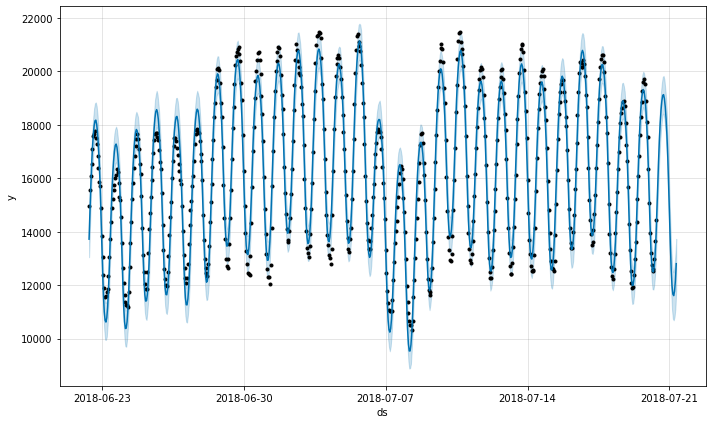

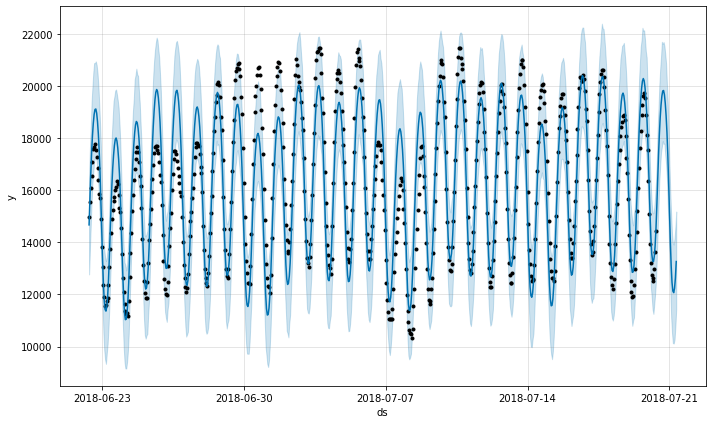

In [58]:
m = Prophet(changepoint_prior_scale=1)
forecast = m.fit(train).predict(future)
fig = m.plot(forecast)
# Python
m = Prophet(changepoint_prior_scale=0.001)
forecast = m.fit(train).predict(future)
fig = m.plot(forecast)

# 24 hours rolling projection

,y,ds,date,day_cost
0,14978.0,2018-06-22 09:00:00,2018-06-22,247728.0
1,15557.0,2018-06-22 10:00:00,2018-06-22,247728.0
2,16087.0,2018-06-22 11:00:00,2018-06-22,247728.0
3,16544.0,2018-06-22 12:00:00,2018-06-22,247728.0
4,17081.0,2018-06-22 13:00:00,2018-06-22,247728.0


(1000, 4)

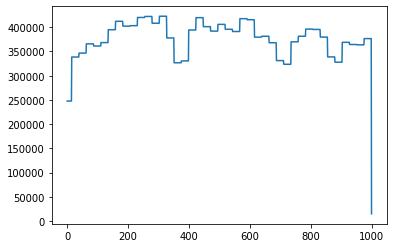

In [59]:
# compute the day cost of the series and merge it to the series
series['date'] = series['ds'].dt.date
day_cost = series.groupby(['date']).sum()
day_cost.columns = ['day_cost']
series = series.merge(day_cost, left_on='date', right_on='date',how='outer')
series.head()
series['day_cost'].plot()
series.shape

In [60]:
# split the data into train - test respecting the number of weeks of training requirement
train, test = series[0:train_length], series[train_length:len(series)]
print('train df shape is '+str(train.shape))
print('test df shape is '+str(test.shape))

train df shape is (672, 4)
test df shape is (328, 4)


In [61]:
# run it
predictions = list()
predictions_eod = list()
import time
start_time = time.time()
print('length of test is: '+str(len(test)))
for t in range(len(test)):
    train = series[0+t:train_length+t]
    m = Prophet(changepoint_prior_scale=.5, daily_seasonality=True,weekly_seasonality=True).fit(train)
    future = m.make_future_dataframe(periods=24, freq='H')
    forecast = m.predict(future)
    yhat = forecast['yhat'].tail(24)
    predictions.append(yhat)
    merged = forecast.merge(train, left_on='ds', right_on='ds',how='outer')
    merged = merged[['ds','y','yhat']]
    merged['date'] = merged['ds'].dt.date
    merged['roll_prediction'] = merged['y']
    merged.roll_prediction.fillna(merged.yhat, inplace=True)
    str(future.tail(24).head(1).values)
    #erged.tail(30)
    merged_group = merged.groupby(['date']).sum()
    date_pred = train['ds'].dt.date.tail(1)
    eod_pred = round(merged_group.loc[date_pred]['roll_prediction'].values[0],0)
    predictions_eod.append(eod_pred)
    print('loop '+ str(t)+ " - time : %s seconds -" % round((time.time() - start_time), 2) +' start prediction time: '+ str(future.tail(24).head(1).values)+' - EOD prediction: '+str(eod_pred))
    del forecast
    del yhat
del t

length of test is: 328


"[['2018-07-20T09:00:00.000000000']]"

loop 0 - time : 4.39 seconds - start prediction time: [['2018-07-20T09:00:00.000000000']] - EOD prediction: 385299.0


"[['2018-07-20T10:00:00.000000000']]"

loop 1 - time : 8.51 seconds - start prediction time: [['2018-07-20T10:00:00.000000000']] - EOD prediction: 387563.0


"[['2018-07-20T11:00:00.000000000']]"

loop 2 - time : 12.64 seconds - start prediction time: [['2018-07-20T11:00:00.000000000']] - EOD prediction: 388285.0


"[['2018-07-20T12:00:00.000000000']]"

loop 3 - time : 16.79 seconds - start prediction time: [['2018-07-20T12:00:00.000000000']] - EOD prediction: 388361.0


"[['2018-07-20T13:00:00.000000000']]"

loop 4 - time : 20.98 seconds - start prediction time: [['2018-07-20T13:00:00.000000000']] - EOD prediction: 387139.0


"[['2018-07-20T14:00:00.000000000']]"

loop 5 - time : 25.04 seconds - start prediction time: [['2018-07-20T14:00:00.000000000']] - EOD prediction: 385361.0


"[['2018-07-20T15:00:00.000000000']]"

loop 6 - time : 29.28 seconds - start prediction time: [['2018-07-20T15:00:00.000000000']] - EOD prediction: 382772.0


"[['2018-07-20T16:00:00.000000000']]"

loop 7 - time : 33.57 seconds - start prediction time: [['2018-07-20T16:00:00.000000000']] - EOD prediction: 380286.0


"[['2018-07-20T17:00:00.000000000']]"

loop 8 - time : 37.54 seconds - start prediction time: [['2018-07-20T17:00:00.000000000']] - EOD prediction: 378034.0


"[['2018-07-20T18:00:00.000000000']]"

loop 9 - time : 41.71 seconds - start prediction time: [['2018-07-20T18:00:00.000000000']] - EOD prediction: 375782.0


"[['2018-07-20T19:00:00.000000000']]"

loop 10 - time : 45.83 seconds - start prediction time: [['2018-07-20T19:00:00.000000000']] - EOD prediction: 373871.0


"[['2018-07-20T20:00:00.000000000']]"

loop 11 - time : 49.73 seconds - start prediction time: [['2018-07-20T20:00:00.000000000']] - EOD prediction: 371799.0


"[['2018-07-20T21:00:00.000000000']]"

loop 12 - time : 53.81 seconds - start prediction time: [['2018-07-20T21:00:00.000000000']] - EOD prediction: 370006.0


"[['2018-07-20T22:00:00.000000000']]"

loop 13 - time : 57.92 seconds - start prediction time: [['2018-07-20T22:00:00.000000000']] - EOD prediction: 368663.0


"[['2018-07-20T23:00:00.000000000']]"

loop 14 - time : 62.06 seconds - start prediction time: [['2018-07-20T23:00:00.000000000']] - EOD prediction: 368145.0


"[['2018-07-21T00:00:00.000000000']]"

loop 15 - time : 66.11 seconds - start prediction time: [['2018-07-21T00:00:00.000000000']] - EOD prediction: 367980.0


"[['2018-07-21T01:00:00.000000000']]"

loop 16 - time : 70.01 seconds - start prediction time: [['2018-07-21T01:00:00.000000000']] - EOD prediction: 324626.0


"[['2018-07-21T02:00:00.000000000']]"

loop 17 - time : 74.1 seconds - start prediction time: [['2018-07-21T02:00:00.000000000']] - EOD prediction: 324987.0


"[['2018-07-21T03:00:00.000000000']]"

loop 18 - time : 78.51 seconds - start prediction time: [['2018-07-21T03:00:00.000000000']] - EOD prediction: 327419.0


"[['2018-07-21T04:00:00.000000000']]"

loop 19 - time : 82.63 seconds - start prediction time: [['2018-07-21T04:00:00.000000000']] - EOD prediction: 330561.0


"[['2018-07-21T05:00:00.000000000']]"

loop 20 - time : 86.64 seconds - start prediction time: [['2018-07-21T05:00:00.000000000']] - EOD prediction: 335262.0


"[['2018-07-21T06:00:00.000000000']]"

loop 21 - time : 90.89 seconds - start prediction time: [['2018-07-21T06:00:00.000000000']] - EOD prediction: 339289.0


"[['2018-07-21T07:00:00.000000000']]"

loop 22 - time : 95.23 seconds - start prediction time: [['2018-07-21T07:00:00.000000000']] - EOD prediction: 343518.0


"[['2018-07-21T08:00:00.000000000']]"

loop 23 - time : 99.61 seconds - start prediction time: [['2018-07-21T08:00:00.000000000']] - EOD prediction: 345300.0


"[['2018-07-21T09:00:00.000000000']]"

loop 24 - time : 103.88 seconds - start prediction time: [['2018-07-21T09:00:00.000000000']] - EOD prediction: 345781.0


"[['2018-07-21T10:00:00.000000000']]"

loop 25 - time : 107.95 seconds - start prediction time: [['2018-07-21T10:00:00.000000000']] - EOD prediction: 345325.0


"[['2018-07-21T11:00:00.000000000']]"

loop 26 - time : 112.13 seconds - start prediction time: [['2018-07-21T11:00:00.000000000']] - EOD prediction: 343410.0


"[['2018-07-21T12:00:00.000000000']]"

loop 27 - time : 116.33 seconds - start prediction time: [['2018-07-21T12:00:00.000000000']] - EOD prediction: 341384.0


"[['2018-07-21T13:00:00.000000000']]"

loop 28 - time : 120.88 seconds - start prediction time: [['2018-07-21T13:00:00.000000000']] - EOD prediction: 338681.0


"[['2018-07-21T14:00:00.000000000']]"

loop 29 - time : 124.93 seconds - start prediction time: [['2018-07-21T14:00:00.000000000']] - EOD prediction: 336387.0


"[['2018-07-21T15:00:00.000000000']]"

loop 30 - time : 128.93 seconds - start prediction time: [['2018-07-21T15:00:00.000000000']] - EOD prediction: 333989.0


"[['2018-07-21T16:00:00.000000000']]"

loop 31 - time : 133.24 seconds - start prediction time: [['2018-07-21T16:00:00.000000000']] - EOD prediction: 331548.0


"[['2018-07-21T17:00:00.000000000']]"

loop 32 - time : 137.38 seconds - start prediction time: [['2018-07-21T17:00:00.000000000']] - EOD prediction: 330117.0


"[['2018-07-21T18:00:00.000000000']]"

loop 33 - time : 141.62 seconds - start prediction time: [['2018-07-21T18:00:00.000000000']] - EOD prediction: 329489.0


"[['2018-07-21T19:00:00.000000000']]"

loop 34 - time : 145.74 seconds - start prediction time: [['2018-07-21T19:00:00.000000000']] - EOD prediction: 329535.0


"[['2018-07-21T20:00:00.000000000']]"

loop 35 - time : 149.97 seconds - start prediction time: [['2018-07-21T20:00:00.000000000']] - EOD prediction: 329402.0


"[['2018-07-21T21:00:00.000000000']]"

loop 36 - time : 154.19 seconds - start prediction time: [['2018-07-21T21:00:00.000000000']] - EOD prediction: 329051.0


"[['2018-07-21T22:00:00.000000000']]"

loop 37 - time : 158.44 seconds - start prediction time: [['2018-07-21T22:00:00.000000000']] - EOD prediction: 329182.0


"[['2018-07-21T23:00:00.000000000']]"

loop 38 - time : 162.67 seconds - start prediction time: [['2018-07-21T23:00:00.000000000']] - EOD prediction: 330068.0


"[['2018-07-22T00:00:00.000000000']]"

loop 39 - time : 166.69 seconds - start prediction time: [['2018-07-22T00:00:00.000000000']] - EOD prediction: 331086.0


"[['2018-07-22T01:00:00.000000000']]"

loop 40 - time : 170.95 seconds - start prediction time: [['2018-07-22T01:00:00.000000000']] - EOD prediction: 315097.0


"[['2018-07-22T02:00:00.000000000']]"

loop 41 - time : 175.28 seconds - start prediction time: [['2018-07-22T02:00:00.000000000']] - EOD prediction: 321943.0


"[['2018-07-22T03:00:00.000000000']]"

loop 42 - time : 179.71 seconds - start prediction time: [['2018-07-22T03:00:00.000000000']] - EOD prediction: 329504.0


"[['2018-07-22T04:00:00.000000000']]"

loop 43 - time : 184.05 seconds - start prediction time: [['2018-07-22T04:00:00.000000000']] - EOD prediction: 337089.0


"[['2018-07-22T05:00:00.000000000']]"

loop 44 - time : 188.31 seconds - start prediction time: [['2018-07-22T05:00:00.000000000']] - EOD prediction: 343986.0


"[['2018-07-22T06:00:00.000000000']]"

loop 45 - time : 192.34 seconds - start prediction time: [['2018-07-22T06:00:00.000000000']] - EOD prediction: 347214.0


"[['2018-07-22T07:00:00.000000000']]"

loop 46 - time : 196.65 seconds - start prediction time: [['2018-07-22T07:00:00.000000000']] - EOD prediction: 348313.0


"[['2018-07-22T08:00:00.000000000']]"

loop 47 - time : 200.81 seconds - start prediction time: [['2018-07-22T08:00:00.000000000']] - EOD prediction: 348384.0


"[['2018-07-22T09:00:00.000000000']]"

loop 48 - time : 205.04 seconds - start prediction time: [['2018-07-22T09:00:00.000000000']] - EOD prediction: 347474.0


"[['2018-07-22T10:00:00.000000000']]"

loop 49 - time : 209.01 seconds - start prediction time: [['2018-07-22T10:00:00.000000000']] - EOD prediction: 346635.0


"[['2018-07-22T11:00:00.000000000']]"

loop 50 - time : 213.16 seconds - start prediction time: [['2018-07-22T11:00:00.000000000']] - EOD prediction: 344650.0


"[['2018-07-22T12:00:00.000000000']]"

loop 51 - time : 217.48 seconds - start prediction time: [['2018-07-22T12:00:00.000000000']] - EOD prediction: 341898.0


"[['2018-07-22T13:00:00.000000000']]"

loop 52 - time : 221.51 seconds - start prediction time: [['2018-07-22T13:00:00.000000000']] - EOD prediction: 337261.0


"[['2018-07-22T14:00:00.000000000']]"

loop 53 - time : 225.31 seconds - start prediction time: [['2018-07-22T14:00:00.000000000']] - EOD prediction: 333458.0


"[['2018-07-22T15:00:00.000000000']]"

loop 54 - time : 229.46 seconds - start prediction time: [['2018-07-22T15:00:00.000000000']] - EOD prediction: 330455.0


"[['2018-07-22T16:00:00.000000000']]"

loop 55 - time : 233.45 seconds - start prediction time: [['2018-07-22T16:00:00.000000000']] - EOD prediction: 327924.0


"[['2018-07-22T17:00:00.000000000']]"

loop 56 - time : 237.32 seconds - start prediction time: [['2018-07-22T17:00:00.000000000']] - EOD prediction: 325478.0


"[['2018-07-22T18:00:00.000000000']]"

loop 57 - time : 241.44 seconds - start prediction time: [['2018-07-22T18:00:00.000000000']] - EOD prediction: 323586.0


"[['2018-07-22T19:00:00.000000000']]"

loop 58 - time : 245.61 seconds - start prediction time: [['2018-07-22T19:00:00.000000000']] - EOD prediction: 322558.0


"[['2018-07-22T20:00:00.000000000']]"

loop 59 - time : 249.76 seconds - start prediction time: [['2018-07-22T20:00:00.000000000']] - EOD prediction: 322120.0


"[['2018-07-22T21:00:00.000000000']]"

loop 60 - time : 254.07 seconds - start prediction time: [['2018-07-22T21:00:00.000000000']] - EOD prediction: 321854.0


"[['2018-07-22T22:00:00.000000000']]"

loop 61 - time : 258.59 seconds - start prediction time: [['2018-07-22T22:00:00.000000000']] - EOD prediction: 321868.0


"[['2018-07-22T23:00:00.000000000']]"

loop 62 - time : 262.86 seconds - start prediction time: [['2018-07-22T23:00:00.000000000']] - EOD prediction: 322566.0


"[['2018-07-23T00:00:00.000000000']]"

loop 63 - time : 266.99 seconds - start prediction time: [['2018-07-23T00:00:00.000000000']] - EOD prediction: 323504.0


"[['2018-07-23T01:00:00.000000000']]"

loop 64 - time : 271.22 seconds - start prediction time: [['2018-07-23T01:00:00.000000000']] - EOD prediction: 324629.0


"[['2018-07-23T02:00:00.000000000']]"

loop 65 - time : 275.49 seconds - start prediction time: [['2018-07-23T02:00:00.000000000']] - EOD prediction: 328818.0


"[['2018-07-23T03:00:00.000000000']]"

loop 66 - time : 279.78 seconds - start prediction time: [['2018-07-23T03:00:00.000000000']] - EOD prediction: 334608.0


"[['2018-07-23T04:00:00.000000000']]"

loop 67 - time : 283.95 seconds - start prediction time: [['2018-07-23T04:00:00.000000000']] - EOD prediction: 340538.0


"[['2018-07-23T05:00:00.000000000']]"

loop 68 - time : 288.29 seconds - start prediction time: [['2018-07-23T05:00:00.000000000']] - EOD prediction: 346295.0


"[['2018-07-23T06:00:00.000000000']]"

loop 69 - time : 292.6 seconds - start prediction time: [['2018-07-23T06:00:00.000000000']] - EOD prediction: 349668.0


"[['2018-07-23T07:00:00.000000000']]"

loop 70 - time : 296.6 seconds - start prediction time: [['2018-07-23T07:00:00.000000000']] - EOD prediction: 352573.0


"[['2018-07-23T08:00:00.000000000']]"

loop 71 - time : 300.62 seconds - start prediction time: [['2018-07-23T08:00:00.000000000']] - EOD prediction: 358446.0


"[['2018-07-23T09:00:00.000000000']]"

loop 72 - time : 304.58 seconds - start prediction time: [['2018-07-23T09:00:00.000000000']] - EOD prediction: 364355.0


"[['2018-07-23T10:00:00.000000000']]"

loop 73 - time : 308.22 seconds - start prediction time: [['2018-07-23T10:00:00.000000000']] - EOD prediction: 367396.0


"[['2018-07-23T11:00:00.000000000']]"

loop 74 - time : 312.37 seconds - start prediction time: [['2018-07-23T11:00:00.000000000']] - EOD prediction: 370347.0


"[['2018-07-23T12:00:00.000000000']]"

loop 75 - time : 316.72 seconds - start prediction time: [['2018-07-23T12:00:00.000000000']] - EOD prediction: 371711.0


"[['2018-07-23T13:00:00.000000000']]"

loop 76 - time : 320.99 seconds - start prediction time: [['2018-07-23T13:00:00.000000000']] - EOD prediction: 372052.0


"[['2018-07-23T14:00:00.000000000']]"

loop 77 - time : 325.45 seconds - start prediction time: [['2018-07-23T14:00:00.000000000']] - EOD prediction: 372366.0


"[['2018-07-23T15:00:00.000000000']]"

loop 78 - time : 329.64 seconds - start prediction time: [['2018-07-23T15:00:00.000000000']] - EOD prediction: 372270.0


"[['2018-07-23T16:00:00.000000000']]"

loop 79 - time : 333.71 seconds - start prediction time: [['2018-07-23T16:00:00.000000000']] - EOD prediction: 372070.0


"[['2018-07-23T17:00:00.000000000']]"

loop 80 - time : 338.32 seconds - start prediction time: [['2018-07-23T17:00:00.000000000']] - EOD prediction: 371826.0


"[['2018-07-23T18:00:00.000000000']]"

loop 81 - time : 344.64 seconds - start prediction time: [['2018-07-23T18:00:00.000000000']] - EOD prediction: 371821.0


"[['2018-07-23T19:00:00.000000000']]"

loop 82 - time : 350.49 seconds - start prediction time: [['2018-07-23T19:00:00.000000000']] - EOD prediction: 371400.0


"[['2018-07-23T20:00:00.000000000']]"

loop 83 - time : 356.18 seconds - start prediction time: [['2018-07-23T20:00:00.000000000']] - EOD prediction: 370764.0


"[['2018-07-23T21:00:00.000000000']]"

loop 84 - time : 361.41 seconds - start prediction time: [['2018-07-23T21:00:00.000000000']] - EOD prediction: 370197.0


"[['2018-07-23T22:00:00.000000000']]"

loop 85 - time : 365.41 seconds - start prediction time: [['2018-07-23T22:00:00.000000000']] - EOD prediction: 369747.0


"[['2018-07-23T23:00:00.000000000']]"

loop 86 - time : 369.76 seconds - start prediction time: [['2018-07-23T23:00:00.000000000']] - EOD prediction: 369893.0


"[['2018-07-24T00:00:00.000000000']]"

loop 87 - time : 373.88 seconds - start prediction time: [['2018-07-24T00:00:00.000000000']] - EOD prediction: 369842.0


"[['2018-07-24T01:00:00.000000000']]"

loop 88 - time : 378.15 seconds - start prediction time: [['2018-07-24T01:00:00.000000000']] - EOD prediction: 375723.0


"[['2018-07-24T02:00:00.000000000']]"

loop 89 - time : 382.42 seconds - start prediction time: [['2018-07-24T02:00:00.000000000']] - EOD prediction: 376631.0


"[['2018-07-24T03:00:00.000000000']]"

loop 90 - time : 386.16 seconds - start prediction time: [['2018-07-24T03:00:00.000000000']] - EOD prediction: 376430.0


"[['2018-07-24T04:00:00.000000000']]"

loop 91 - time : 390.34 seconds - start prediction time: [['2018-07-24T04:00:00.000000000']] - EOD prediction: 379037.0


"[['2018-07-24T05:00:00.000000000']]"

loop 92 - time : 393.93 seconds - start prediction time: [['2018-07-24T05:00:00.000000000']] - EOD prediction: 379858.0


"[['2018-07-24T06:00:00.000000000']]"

loop 93 - time : 398.19 seconds - start prediction time: [['2018-07-24T06:00:00.000000000']] - EOD prediction: 381829.0


"[['2018-07-24T07:00:00.000000000']]"

loop 94 - time : 402.15 seconds - start prediction time: [['2018-07-24T07:00:00.000000000']] - EOD prediction: 383457.0


"[['2018-07-24T08:00:00.000000000']]"

loop 95 - time : 406.5 seconds - start prediction time: [['2018-07-24T08:00:00.000000000']] - EOD prediction: 385521.0


"[['2018-07-24T09:00:00.000000000']]"

loop 96 - time : 410.67 seconds - start prediction time: [['2018-07-24T09:00:00.000000000']] - EOD prediction: 387463.0


"[['2018-07-24T10:00:00.000000000']]"

loop 97 - time : 414.74 seconds - start prediction time: [['2018-07-24T10:00:00.000000000']] - EOD prediction: 389050.0


"[['2018-07-24T11:00:00.000000000']]"

loop 98 - time : 419.0 seconds - start prediction time: [['2018-07-24T11:00:00.000000000']] - EOD prediction: 387298.0


"[['2018-07-24T12:00:00.000000000']]"

loop 99 - time : 423.19 seconds - start prediction time: [['2018-07-24T12:00:00.000000000']] - EOD prediction: 386349.0


"[['2018-07-24T13:00:00.000000000']]"

loop 100 - time : 427.2 seconds - start prediction time: [['2018-07-24T13:00:00.000000000']] - EOD prediction: 384926.0


"[['2018-07-24T14:00:00.000000000']]"

loop 101 - time : 431.31 seconds - start prediction time: [['2018-07-24T14:00:00.000000000']] - EOD prediction: 382675.0


"[['2018-07-24T15:00:00.000000000']]"

loop 102 - time : 435.58 seconds - start prediction time: [['2018-07-24T15:00:00.000000000']] - EOD prediction: 381715.0


"[['2018-07-24T16:00:00.000000000']]"

loop 103 - time : 440.06 seconds - start prediction time: [['2018-07-24T16:00:00.000000000']] - EOD prediction: 381108.0


"[['2018-07-24T17:00:00.000000000']]"

loop 104 - time : 444.2 seconds - start prediction time: [['2018-07-24T17:00:00.000000000']] - EOD prediction: 380578.0


"[['2018-07-24T18:00:00.000000000']]"

loop 105 - time : 448.16 seconds - start prediction time: [['2018-07-24T18:00:00.000000000']] - EOD prediction: 380163.0


"[['2018-07-24T19:00:00.000000000']]"

loop 106 - time : 452.36 seconds - start prediction time: [['2018-07-24T19:00:00.000000000']] - EOD prediction: 379611.0


"[['2018-07-24T20:00:00.000000000']]"

loop 107 - time : 456.51 seconds - start prediction time: [['2018-07-24T20:00:00.000000000']] - EOD prediction: 379489.0


"[['2018-07-24T21:00:00.000000000']]"

loop 108 - time : 460.8 seconds - start prediction time: [['2018-07-24T21:00:00.000000000']] - EOD prediction: 379357.0


"[['2018-07-24T22:00:00.000000000']]"

loop 109 - time : 465.28 seconds - start prediction time: [['2018-07-24T22:00:00.000000000']] - EOD prediction: 379803.0


"[['2018-07-24T23:00:00.000000000']]"

loop 110 - time : 469.42 seconds - start prediction time: [['2018-07-24T23:00:00.000000000']] - EOD prediction: 380701.0


"[['2018-07-25T00:00:00.000000000']]"

loop 111 - time : 473.31 seconds - start prediction time: [['2018-07-25T00:00:00.000000000']] - EOD prediction: 381373.0


"[['2018-07-25T01:00:00.000000000']]"

loop 112 - time : 477.51 seconds - start prediction time: [['2018-07-25T01:00:00.000000000']] - EOD prediction: 360809.0


"[['2018-07-25T02:00:00.000000000']]"

loop 113 - time : 481.58 seconds - start prediction time: [['2018-07-25T02:00:00.000000000']] - EOD prediction: 363110.0


"[['2018-07-25T03:00:00.000000000']]"

loop 114 - time : 485.64 seconds - start prediction time: [['2018-07-25T03:00:00.000000000']] - EOD prediction: 366516.0


"[['2018-07-25T04:00:00.000000000']]"

loop 115 - time : 489.99 seconds - start prediction time: [['2018-07-25T04:00:00.000000000']] - EOD prediction: 369394.0


"[['2018-07-25T05:00:00.000000000']]"

loop 116 - time : 494.06 seconds - start prediction time: [['2018-07-25T05:00:00.000000000']] - EOD prediction: 372045.0


"[['2018-07-25T06:00:00.000000000']]"

loop 117 - time : 498.04 seconds - start prediction time: [['2018-07-25T06:00:00.000000000']] - EOD prediction: 374669.0


"[['2018-07-25T07:00:00.000000000']]"

loop 118 - time : 502.3 seconds - start prediction time: [['2018-07-25T07:00:00.000000000']] - EOD prediction: 378041.0


"[['2018-07-25T08:00:00.000000000']]"

loop 119 - time : 506.64 seconds - start prediction time: [['2018-07-25T08:00:00.000000000']] - EOD prediction: 382364.0


"[['2018-07-25T09:00:00.000000000']]"

loop 120 - time : 510.71 seconds - start prediction time: [['2018-07-25T09:00:00.000000000']] - EOD prediction: 386249.0


"[['2018-07-25T10:00:00.000000000']]"

loop 121 - time : 514.64 seconds - start prediction time: [['2018-07-25T10:00:00.000000000']] - EOD prediction: 388849.0


"[['2018-07-25T11:00:00.000000000']]"

loop 122 - time : 518.81 seconds - start prediction time: [['2018-07-25T11:00:00.000000000']] - EOD prediction: 390812.0


"[['2018-07-25T12:00:00.000000000']]"

loop 123 - time : 522.91 seconds - start prediction time: [['2018-07-25T12:00:00.000000000']] - EOD prediction: 392440.0


"[['2018-07-25T13:00:00.000000000']]"

loop 124 - time : 527.31 seconds - start prediction time: [['2018-07-25T13:00:00.000000000']] - EOD prediction: 393907.0


"[['2018-07-25T14:00:00.000000000']]"

loop 125 - time : 531.33 seconds - start prediction time: [['2018-07-25T14:00:00.000000000']] - EOD prediction: 394925.0


"[['2018-07-25T15:00:00.000000000']]"

loop 126 - time : 535.26 seconds - start prediction time: [['2018-07-25T15:00:00.000000000']] - EOD prediction: 396066.0


"[['2018-07-25T16:00:00.000000000']]"

loop 127 - time : 539.14 seconds - start prediction time: [['2018-07-25T16:00:00.000000000']] - EOD prediction: 397192.0


"[['2018-07-25T17:00:00.000000000']]"

loop 128 - time : 543.3 seconds - start prediction time: [['2018-07-25T17:00:00.000000000']] - EOD prediction: 397439.0


"[['2018-07-25T18:00:00.000000000']]"

loop 129 - time : 547.6 seconds - start prediction time: [['2018-07-25T18:00:00.000000000']] - EOD prediction: 397481.0


"[['2018-07-25T19:00:00.000000000']]"

loop 130 - time : 551.81 seconds - start prediction time: [['2018-07-25T19:00:00.000000000']] - EOD prediction: 397432.0


"[['2018-07-25T20:00:00.000000000']]"

loop 131 - time : 555.92 seconds - start prediction time: [['2018-07-25T20:00:00.000000000']] - EOD prediction: 397166.0


"[['2018-07-25T21:00:00.000000000']]"

loop 132 - time : 560.07 seconds - start prediction time: [['2018-07-25T21:00:00.000000000']] - EOD prediction: 397004.0


"[['2018-07-25T22:00:00.000000000']]"

loop 133 - time : 564.03 seconds - start prediction time: [['2018-07-25T22:00:00.000000000']] - EOD prediction: 396606.0


"[['2018-07-25T23:00:00.000000000']]"

loop 134 - time : 568.25 seconds - start prediction time: [['2018-07-25T23:00:00.000000000']] - EOD prediction: 396509.0


"[['2018-07-26T00:00:00.000000000']]"

loop 135 - time : 572.54 seconds - start prediction time: [['2018-07-26T00:00:00.000000000']] - EOD prediction: 396080.0


"[['2018-07-26T01:00:00.000000000']]"

loop 136 - time : 576.83 seconds - start prediction time: [['2018-07-26T01:00:00.000000000']] - EOD prediction: 405675.0


"[['2018-07-26T02:00:00.000000000']]"

loop 137 - time : 580.77 seconds - start prediction time: [['2018-07-26T02:00:00.000000000']] - EOD prediction: 402467.0


"[['2018-07-26T03:00:00.000000000']]"

loop 138 - time : 584.76 seconds - start prediction time: [['2018-07-26T03:00:00.000000000']] - EOD prediction: 400279.0


"[['2018-07-26T04:00:00.000000000']]"

loop 139 - time : 588.97 seconds - start prediction time: [['2018-07-26T04:00:00.000000000']] - EOD prediction: 400074.0


"[['2018-07-26T05:00:00.000000000']]"

loop 140 - time : 593.09 seconds - start prediction time: [['2018-07-26T05:00:00.000000000']] - EOD prediction: 399613.0


"[['2018-07-26T06:00:00.000000000']]"

loop 141 - time : 597.06 seconds - start prediction time: [['2018-07-26T06:00:00.000000000']] - EOD prediction: 398896.0


"[['2018-07-26T07:00:00.000000000']]"

loop 142 - time : 601.22 seconds - start prediction time: [['2018-07-26T07:00:00.000000000']] - EOD prediction: 398282.0


"[['2018-07-26T08:00:00.000000000']]"

loop 143 - time : 605.29 seconds - start prediction time: [['2018-07-26T08:00:00.000000000']] - EOD prediction: 399176.0


"[['2018-07-26T09:00:00.000000000']]"

loop 144 - time : 609.58 seconds - start prediction time: [['2018-07-26T09:00:00.000000000']] - EOD prediction: 399955.0


"[['2018-07-26T10:00:00.000000000']]"

loop 145 - time : 613.8 seconds - start prediction time: [['2018-07-26T10:00:00.000000000']] - EOD prediction: 400397.0


"[['2018-07-26T11:00:00.000000000']]"

loop 146 - time : 617.63 seconds - start prediction time: [['2018-07-26T11:00:00.000000000']] - EOD prediction: 399774.0


"[['2018-07-26T12:00:00.000000000']]"

loop 147 - time : 621.61 seconds - start prediction time: [['2018-07-26T12:00:00.000000000']] - EOD prediction: 399067.0


"[['2018-07-26T13:00:00.000000000']]"

loop 148 - time : 625.69 seconds - start prediction time: [['2018-07-26T13:00:00.000000000']] - EOD prediction: 398552.0


"[['2018-07-26T14:00:00.000000000']]"

loop 149 - time : 630.28 seconds - start prediction time: [['2018-07-26T14:00:00.000000000']] - EOD prediction: 397985.0


"[['2018-07-26T15:00:00.000000000']]"

loop 150 - time : 634.37 seconds - start prediction time: [['2018-07-26T15:00:00.000000000']] - EOD prediction: 397025.0


"[['2018-07-26T16:00:00.000000000']]"

loop 151 - time : 638.47 seconds - start prediction time: [['2018-07-26T16:00:00.000000000']] - EOD prediction: 396840.0


"[['2018-07-26T17:00:00.000000000']]"

loop 152 - time : 642.74 seconds - start prediction time: [['2018-07-26T17:00:00.000000000']] - EOD prediction: 396680.0


"[['2018-07-26T18:00:00.000000000']]"

loop 153 - time : 646.98 seconds - start prediction time: [['2018-07-26T18:00:00.000000000']] - EOD prediction: 396733.0


"[['2018-07-26T19:00:00.000000000']]"

loop 154 - time : 651.3 seconds - start prediction time: [['2018-07-26T19:00:00.000000000']] - EOD prediction: 396659.0


"[['2018-07-26T20:00:00.000000000']]"

loop 155 - time : 655.4 seconds - start prediction time: [['2018-07-26T20:00:00.000000000']] - EOD prediction: 396574.0


"[['2018-07-26T21:00:00.000000000']]"

loop 156 - time : 659.82 seconds - start prediction time: [['2018-07-26T21:00:00.000000000']] - EOD prediction: 396251.0


"[['2018-07-26T22:00:00.000000000']]"

loop 157 - time : 663.79 seconds - start prediction time: [['2018-07-26T22:00:00.000000000']] - EOD prediction: 395836.0


"[['2018-07-26T23:00:00.000000000']]"

loop 158 - time : 667.74 seconds - start prediction time: [['2018-07-26T23:00:00.000000000']] - EOD prediction: 395782.0


"[['2018-07-27T00:00:00.000000000']]"

loop 159 - time : 671.79 seconds - start prediction time: [['2018-07-27T00:00:00.000000000']] - EOD prediction: 395382.0


"[['2018-07-27T01:00:00.000000000']]"

loop 160 - time : 675.75 seconds - start prediction time: [['2018-07-27T01:00:00.000000000']] - EOD prediction: 386111.0


"[['2018-07-27T02:00:00.000000000']]"

loop 161 - time : 679.99 seconds - start prediction time: [['2018-07-27T02:00:00.000000000']] - EOD prediction: 384729.0


"[['2018-07-27T03:00:00.000000000']]"

loop 162 - time : 683.97 seconds - start prediction time: [['2018-07-27T03:00:00.000000000']] - EOD prediction: 384589.0


"[['2018-07-27T04:00:00.000000000']]"

loop 163 - time : 688.16 seconds - start prediction time: [['2018-07-27T04:00:00.000000000']] - EOD prediction: 384907.0


"[['2018-07-27T05:00:00.000000000']]"

loop 164 - time : 692.34 seconds - start prediction time: [['2018-07-27T05:00:00.000000000']] - EOD prediction: 384316.0


"[['2018-07-27T06:00:00.000000000']]"

loop 165 - time : 696.51 seconds - start prediction time: [['2018-07-27T06:00:00.000000000']] - EOD prediction: 384418.0


"[['2018-07-27T07:00:00.000000000']]"

loop 166 - time : 700.49 seconds - start prediction time: [['2018-07-27T07:00:00.000000000']] - EOD prediction: 384790.0


"[['2018-07-27T08:00:00.000000000']]"

loop 167 - time : 704.16 seconds - start prediction time: [['2018-07-27T08:00:00.000000000']] - EOD prediction: 385604.0


"[['2018-07-27T09:00:00.000000000']]"

loop 168 - time : 708.42 seconds - start prediction time: [['2018-07-27T09:00:00.000000000']] - EOD prediction: 385816.0


"[['2018-07-27T10:00:00.000000000']]"

loop 169 - time : 712.88 seconds - start prediction time: [['2018-07-27T10:00:00.000000000']] - EOD prediction: 385680.0


"[['2018-07-27T11:00:00.000000000']]"

loop 170 - time : 716.87 seconds - start prediction time: [['2018-07-27T11:00:00.000000000']] - EOD prediction: 385337.0


"[['2018-07-27T12:00:00.000000000']]"

loop 171 - time : 720.72 seconds - start prediction time: [['2018-07-27T12:00:00.000000000']] - EOD prediction: 384590.0


"[['2018-07-27T13:00:00.000000000']]"

loop 172 - time : 724.88 seconds - start prediction time: [['2018-07-27T13:00:00.000000000']] - EOD prediction: 383451.0


"[['2018-07-27T14:00:00.000000000']]"

loop 173 - time : 728.98 seconds - start prediction time: [['2018-07-27T14:00:00.000000000']] - EOD prediction: 382135.0


"[['2018-07-27T15:00:00.000000000']]"

loop 174 - time : 733.24 seconds - start prediction time: [['2018-07-27T15:00:00.000000000']] - EOD prediction: 381660.0


"[['2018-07-27T16:00:00.000000000']]"

loop 175 - time : 737.3 seconds - start prediction time: [['2018-07-27T16:00:00.000000000']] - EOD prediction: 381247.0


"[['2018-07-27T17:00:00.000000000']]"

loop 176 - time : 741.57 seconds - start prediction time: [['2018-07-27T17:00:00.000000000']] - EOD prediction: 380834.0


"[['2018-07-27T18:00:00.000000000']]"

loop 177 - time : 745.46 seconds - start prediction time: [['2018-07-27T18:00:00.000000000']] - EOD prediction: 380554.0


"[['2018-07-27T19:00:00.000000000']]"

loop 178 - time : 749.62 seconds - start prediction time: [['2018-07-27T19:00:00.000000000']] - EOD prediction: 380374.0


"[['2018-07-27T20:00:00.000000000']]"

loop 179 - time : 753.66 seconds - start prediction time: [['2018-07-27T20:00:00.000000000']] - EOD prediction: 380157.0


"[['2018-07-27T21:00:00.000000000']]"

loop 180 - time : 757.85 seconds - start prediction time: [['2018-07-27T21:00:00.000000000']] - EOD prediction: 379970.0


"[['2018-07-27T22:00:00.000000000']]"

loop 181 - time : 761.86 seconds - start prediction time: [['2018-07-27T22:00:00.000000000']] - EOD prediction: 379589.0


"[['2018-07-27T23:00:00.000000000']]"

loop 182 - time : 766.1 seconds - start prediction time: [['2018-07-27T23:00:00.000000000']] - EOD prediction: 379617.0


"[['2018-07-28T00:00:00.000000000']]"

loop 183 - time : 770.43 seconds - start prediction time: [['2018-07-28T00:00:00.000000000']] - EOD prediction: 379599.0


"[['2018-07-28T01:00:00.000000000']]"

loop 184 - time : 774.72 seconds - start prediction time: [['2018-07-28T01:00:00.000000000']] - EOD prediction: 339563.0


"[['2018-07-28T02:00:00.000000000']]"

loop 185 - time : 778.88 seconds - start prediction time: [['2018-07-28T02:00:00.000000000']] - EOD prediction: 341801.0


"[['2018-07-28T03:00:00.000000000']]"

loop 186 - time : 782.78 seconds - start prediction time: [['2018-07-28T03:00:00.000000000']] - EOD prediction: 343384.0


"[['2018-07-28T04:00:00.000000000']]"

loop 187 - time : 787.04 seconds - start prediction time: [['2018-07-28T04:00:00.000000000']] - EOD prediction: 347098.0


"[['2018-07-28T05:00:00.000000000']]"

loop 188 - time : 791.2 seconds - start prediction time: [['2018-07-28T05:00:00.000000000']] - EOD prediction: 350914.0


"[['2018-07-28T06:00:00.000000000']]"

loop 189 - time : 795.55 seconds - start prediction time: [['2018-07-28T06:00:00.000000000']] - EOD prediction: 353410.0


"[['2018-07-28T07:00:00.000000000']]"

loop 190 - time : 799.82 seconds - start prediction time: [['2018-07-28T07:00:00.000000000']] - EOD prediction: 355019.0


"[['2018-07-28T08:00:00.000000000']]"

loop 191 - time : 804.25 seconds - start prediction time: [['2018-07-28T08:00:00.000000000']] - EOD prediction: 354194.0


"[['2018-07-28T09:00:00.000000000']]"

loop 192 - time : 808.41 seconds - start prediction time: [['2018-07-28T09:00:00.000000000']] - EOD prediction: 352095.0


"[['2018-07-28T10:00:00.000000000']]"

loop 193 - time : 812.7 seconds - start prediction time: [['2018-07-28T10:00:00.000000000']] - EOD prediction: 350107.0


"[['2018-07-28T11:00:00.000000000']]"

loop 194 - time : 816.98 seconds - start prediction time: [['2018-07-28T11:00:00.000000000']] - EOD prediction: 347529.0


"[['2018-07-28T12:00:00.000000000']]"

loop 195 - time : 821.1 seconds - start prediction time: [['2018-07-28T12:00:00.000000000']] - EOD prediction: 345165.0


"[['2018-07-28T13:00:00.000000000']]"

loop 196 - time : 825.45 seconds - start prediction time: [['2018-07-28T13:00:00.000000000']] - EOD prediction: 343283.0


"[['2018-07-28T14:00:00.000000000']]"

loop 197 - time : 829.84 seconds - start prediction time: [['2018-07-28T14:00:00.000000000']] - EOD prediction: 341204.0


"[['2018-07-28T15:00:00.000000000']]"

loop 198 - time : 834.09 seconds - start prediction time: [['2018-07-28T15:00:00.000000000']] - EOD prediction: 339421.0


"[['2018-07-28T16:00:00.000000000']]"

loop 199 - time : 838.11 seconds - start prediction time: [['2018-07-28T16:00:00.000000000']] - EOD prediction: 338211.0


"[['2018-07-28T17:00:00.000000000']]"

loop 200 - time : 842.14 seconds - start prediction time: [['2018-07-28T17:00:00.000000000']] - EOD prediction: 337421.0


"[['2018-07-28T18:00:00.000000000']]"

loop 201 - time : 846.0 seconds - start prediction time: [['2018-07-28T18:00:00.000000000']] - EOD prediction: 337212.0


"[['2018-07-28T19:00:00.000000000']]"

loop 202 - time : 850.19 seconds - start prediction time: [['2018-07-28T19:00:00.000000000']] - EOD prediction: 337523.0


"[['2018-07-28T20:00:00.000000000']]"

loop 203 - time : 854.41 seconds - start prediction time: [['2018-07-28T20:00:00.000000000']] - EOD prediction: 337799.0


"[['2018-07-28T21:00:00.000000000']]"

loop 204 - time : 858.44 seconds - start prediction time: [['2018-07-28T21:00:00.000000000']] - EOD prediction: 337795.0


"[['2018-07-28T22:00:00.000000000']]"

loop 205 - time : 862.72 seconds - start prediction time: [['2018-07-28T22:00:00.000000000']] - EOD prediction: 337749.0


"[['2018-07-28T23:00:00.000000000']]"

loop 206 - time : 866.36 seconds - start prediction time: [['2018-07-28T23:00:00.000000000']] - EOD prediction: 338262.0


"[['2018-07-29T00:00:00.000000000']]"

loop 207 - time : 870.74 seconds - start prediction time: [['2018-07-29T00:00:00.000000000']] - EOD prediction: 338714.0


"[['2018-07-29T01:00:00.000000000']]"

loop 208 - time : 875.45 seconds - start prediction time: [['2018-07-29T01:00:00.000000000']] - EOD prediction: 331919.0


"[['2018-07-29T02:00:00.000000000']]"

loop 209 - time : 879.67 seconds - start prediction time: [['2018-07-29T02:00:00.000000000']] - EOD prediction: 336446.0


"[['2018-07-29T03:00:00.000000000']]"

loop 210 - time : 884.05 seconds - start prediction time: [['2018-07-29T03:00:00.000000000']] - EOD prediction: 341655.0


"[['2018-07-29T04:00:00.000000000']]"

loop 211 - time : 888.05 seconds - start prediction time: [['2018-07-29T04:00:00.000000000']] - EOD prediction: 346590.0


"[['2018-07-29T05:00:00.000000000']]"

loop 212 - time : 892.15 seconds - start prediction time: [['2018-07-29T05:00:00.000000000']] - EOD prediction: 350898.0


"[['2018-07-29T06:00:00.000000000']]"

loop 213 - time : 896.33 seconds - start prediction time: [['2018-07-29T06:00:00.000000000']] - EOD prediction: 352404.0


"[['2018-07-29T07:00:00.000000000']]"

loop 214 - time : 900.44 seconds - start prediction time: [['2018-07-29T07:00:00.000000000']] - EOD prediction: 352555.0


"[['2018-07-29T08:00:00.000000000']]"

loop 215 - time : 904.52 seconds - start prediction time: [['2018-07-29T08:00:00.000000000']] - EOD prediction: 350292.0


"[['2018-07-29T09:00:00.000000000']]"

loop 216 - time : 908.64 seconds - start prediction time: [['2018-07-29T09:00:00.000000000']] - EOD prediction: 346937.0


"[['2018-07-29T10:00:00.000000000']]"

loop 217 - time : 912.87 seconds - start prediction time: [['2018-07-29T10:00:00.000000000']] - EOD prediction: 343508.0


"[['2018-07-29T11:00:00.000000000']]"

loop 218 - time : 916.87 seconds - start prediction time: [['2018-07-29T11:00:00.000000000']] - EOD prediction: 340199.0


"[['2018-07-29T12:00:00.000000000']]"

loop 219 - time : 921.04 seconds - start prediction time: [['2018-07-29T12:00:00.000000000']] - EOD prediction: 336932.0


"[['2018-07-29T13:00:00.000000000']]"

loop 220 - time : 925.1 seconds - start prediction time: [['2018-07-29T13:00:00.000000000']] - EOD prediction: 334208.0


"[['2018-07-29T14:00:00.000000000']]"

loop 221 - time : 929.46 seconds - start prediction time: [['2018-07-29T14:00:00.000000000']] - EOD prediction: 332806.0


"[['2018-07-29T15:00:00.000000000']]"

loop 222 - time : 933.55 seconds - start prediction time: [['2018-07-29T15:00:00.000000000']] - EOD prediction: 331529.0


"[['2018-07-29T16:00:00.000000000']]"

loop 223 - time : 937.56 seconds - start prediction time: [['2018-07-29T16:00:00.000000000']] - EOD prediction: 329595.0


"[['2018-07-29T17:00:00.000000000']]"

loop 224 - time : 941.5 seconds - start prediction time: [['2018-07-29T17:00:00.000000000']] - EOD prediction: 327952.0


"[['2018-07-29T18:00:00.000000000']]"

loop 225 - time : 945.58 seconds - start prediction time: [['2018-07-29T18:00:00.000000000']] - EOD prediction: 326998.0


"[['2018-07-29T19:00:00.000000000']]"

loop 226 - time : 949.65 seconds - start prediction time: [['2018-07-29T19:00:00.000000000']] - EOD prediction: 326537.0


"[['2018-07-29T20:00:00.000000000']]"

loop 227 - time : 953.69 seconds - start prediction time: [['2018-07-29T20:00:00.000000000']] - EOD prediction: 326475.0


"[['2018-07-29T21:00:00.000000000']]"

loop 228 - time : 957.84 seconds - start prediction time: [['2018-07-29T21:00:00.000000000']] - EOD prediction: 326367.0


"[['2018-07-29T22:00:00.000000000']]"

loop 229 - time : 962.04 seconds - start prediction time: [['2018-07-29T22:00:00.000000000']] - EOD prediction: 326477.0


"[['2018-07-29T23:00:00.000000000']]"

loop 230 - time : 966.15 seconds - start prediction time: [['2018-07-29T23:00:00.000000000']] - EOD prediction: 327161.0


"[['2018-07-30T00:00:00.000000000']]"

loop 231 - time : 970.41 seconds - start prediction time: [['2018-07-30T00:00:00.000000000']] - EOD prediction: 327792.0


"[['2018-07-30T01:00:00.000000000']]"

loop 232 - time : 974.38 seconds - start prediction time: [['2018-07-30T01:00:00.000000000']] - EOD prediction: 356670.0


"[['2018-07-30T02:00:00.000000000']]"

loop 233 - time : 978.36 seconds - start prediction time: [['2018-07-30T02:00:00.000000000']] - EOD prediction: 359624.0


"[['2018-07-30T03:00:00.000000000']]"

loop 234 - time : 982.38 seconds - start prediction time: [['2018-07-30T03:00:00.000000000']] - EOD prediction: 363321.0


"[['2018-07-30T04:00:00.000000000']]"

loop 235 - time : 986.62 seconds - start prediction time: [['2018-07-30T04:00:00.000000000']] - EOD prediction: 368102.0


"[['2018-07-30T05:00:00.000000000']]"

loop 236 - time : 990.6 seconds - start prediction time: [['2018-07-30T05:00:00.000000000']] - EOD prediction: 371293.0


"[['2018-07-30T06:00:00.000000000']]"

loop 237 - time : 994.73 seconds - start prediction time: [['2018-07-30T06:00:00.000000000']] - EOD prediction: 375535.0


"[['2018-07-30T07:00:00.000000000']]"

loop 238 - time : 999.07 seconds - start prediction time: [['2018-07-30T07:00:00.000000000']] - EOD prediction: 379391.0


"[['2018-07-30T08:00:00.000000000']]"

loop 239 - time : 1003.32 seconds - start prediction time: [['2018-07-30T08:00:00.000000000']] - EOD prediction: 383400.0


"[['2018-07-30T09:00:00.000000000']]"

loop 240 - time : 1007.61 seconds - start prediction time: [['2018-07-30T09:00:00.000000000']] - EOD prediction: 386475.0


"[['2018-07-30T10:00:00.000000000']]"

loop 241 - time : 1011.73 seconds - start prediction time: [['2018-07-30T10:00:00.000000000']] - EOD prediction: 387376.0


"[['2018-07-30T11:00:00.000000000']]"

loop 242 - time : 1015.81 seconds - start prediction time: [['2018-07-30T11:00:00.000000000']] - EOD prediction: 386606.0


"[['2018-07-30T12:00:00.000000000']]"

loop 243 - time : 1019.81 seconds - start prediction time: [['2018-07-30T12:00:00.000000000']] - EOD prediction: 385188.0


"[['2018-07-30T13:00:00.000000000']]"

loop 244 - time : 1023.74 seconds - start prediction time: [['2018-07-30T13:00:00.000000000']] - EOD prediction: 383088.0


"[['2018-07-30T14:00:00.000000000']]"

loop 245 - time : 1028.12 seconds - start prediction time: [['2018-07-30T14:00:00.000000000']] - EOD prediction: 381375.0


"[['2018-07-30T15:00:00.000000000']]"

loop 246 - time : 1032.27 seconds - start prediction time: [['2018-07-30T15:00:00.000000000']] - EOD prediction: 379959.0


"[['2018-07-30T16:00:00.000000000']]"

loop 247 - time : 1036.41 seconds - start prediction time: [['2018-07-30T16:00:00.000000000']] - EOD prediction: 378220.0


"[['2018-07-30T17:00:00.000000000']]"

loop 248 - time : 1040.37 seconds - start prediction time: [['2018-07-30T17:00:00.000000000']] - EOD prediction: 376152.0


"[['2018-07-30T18:00:00.000000000']]"

loop 249 - time : 1044.16 seconds - start prediction time: [['2018-07-30T18:00:00.000000000']] - EOD prediction: 374370.0


"[['2018-07-30T19:00:00.000000000']]"

loop 250 - time : 1048.33 seconds - start prediction time: [['2018-07-30T19:00:00.000000000']] - EOD prediction: 372868.0


"[['2018-07-30T20:00:00.000000000']]"

loop 251 - time : 1052.58 seconds - start prediction time: [['2018-07-30T20:00:00.000000000']] - EOD prediction: 371395.0


"[['2018-07-30T21:00:00.000000000']]"

loop 252 - time : 1057.07 seconds - start prediction time: [['2018-07-30T21:00:00.000000000']] - EOD prediction: 369970.0


"[['2018-07-30T22:00:00.000000000']]"

loop 253 - time : 1061.28 seconds - start prediction time: [['2018-07-30T22:00:00.000000000']] - EOD prediction: 369153.0


"[['2018-07-30T23:00:00.000000000']]"

loop 254 - time : 1065.71 seconds - start prediction time: [['2018-07-30T23:00:00.000000000']] - EOD prediction: 369063.0


"[['2018-07-31T00:00:00.000000000']]"

loop 255 - time : 1069.92 seconds - start prediction time: [['2018-07-31T00:00:00.000000000']] - EOD prediction: 368834.0


"[['2018-07-31T01:00:00.000000000']]"

loop 256 - time : 1074.42 seconds - start prediction time: [['2018-07-31T01:00:00.000000000']] - EOD prediction: 365866.0


"[['2018-07-31T02:00:00.000000000']]"

loop 257 - time : 1078.73 seconds - start prediction time: [['2018-07-31T02:00:00.000000000']] - EOD prediction: 366440.0


"[['2018-07-31T03:00:00.000000000']]"

loop 258 - time : 1082.94 seconds - start prediction time: [['2018-07-31T03:00:00.000000000']] - EOD prediction: 367415.0


"[['2018-07-31T04:00:00.000000000']]"

loop 259 - time : 1087.37 seconds - start prediction time: [['2018-07-31T04:00:00.000000000']] - EOD prediction: 367413.0


"[['2018-07-31T05:00:00.000000000']]"

loop 260 - time : 1091.26 seconds - start prediction time: [['2018-07-31T05:00:00.000000000']] - EOD prediction: 370050.0


"[['2018-07-31T06:00:00.000000000']]"

loop 261 - time : 1095.48 seconds - start prediction time: [['2018-07-31T06:00:00.000000000']] - EOD prediction: 371050.0


"[['2018-07-31T07:00:00.000000000']]"

loop 262 - time : 1099.91 seconds - start prediction time: [['2018-07-31T07:00:00.000000000']] - EOD prediction: 372829.0


"[['2018-07-31T08:00:00.000000000']]"

loop 263 - time : 1103.95 seconds - start prediction time: [['2018-07-31T08:00:00.000000000']] - EOD prediction: 374713.0


"[['2018-07-31T09:00:00.000000000']]"

loop 264 - time : 1108.13 seconds - start prediction time: [['2018-07-31T09:00:00.000000000']] - EOD prediction: 377669.0


"[['2018-07-31T10:00:00.000000000']]"

loop 265 - time : 1112.23 seconds - start prediction time: [['2018-07-31T10:00:00.000000000']] - EOD prediction: 378746.0


"[['2018-07-31T11:00:00.000000000']]"

loop 266 - time : 1116.79 seconds - start prediction time: [['2018-07-31T11:00:00.000000000']] - EOD prediction: 378806.0


"[['2018-07-31T12:00:00.000000000']]"

loop 267 - time : 1121.27 seconds - start prediction time: [['2018-07-31T12:00:00.000000000']] - EOD prediction: 378046.0


"[['2018-07-31T13:00:00.000000000']]"

loop 268 - time : 1125.44 seconds - start prediction time: [['2018-07-31T13:00:00.000000000']] - EOD prediction: 376396.0


"[['2018-07-31T14:00:00.000000000']]"

loop 269 - time : 1129.78 seconds - start prediction time: [['2018-07-31T14:00:00.000000000']] - EOD prediction: 374782.0


"[['2018-07-31T15:00:00.000000000']]"

loop 270 - time : 1133.78 seconds - start prediction time: [['2018-07-31T15:00:00.000000000']] - EOD prediction: 372614.0


"[['2018-07-31T16:00:00.000000000']]"

loop 271 - time : 1137.96 seconds - start prediction time: [['2018-07-31T16:00:00.000000000']] - EOD prediction: 369895.0


"[['2018-07-31T17:00:00.000000000']]"

loop 272 - time : 1142.07 seconds - start prediction time: [['2018-07-31T17:00:00.000000000']] - EOD prediction: 367078.0


"[['2018-07-31T18:00:00.000000000']]"

loop 273 - time : 1146.34 seconds - start prediction time: [['2018-07-31T18:00:00.000000000']] - EOD prediction: 364542.0


"[['2018-07-31T19:00:00.000000000']]"

loop 274 - time : 1150.47 seconds - start prediction time: [['2018-07-31T19:00:00.000000000']] - EOD prediction: 363251.0


"[['2018-07-31T20:00:00.000000000']]"

loop 275 - time : 1154.6 seconds - start prediction time: [['2018-07-31T20:00:00.000000000']] - EOD prediction: 362210.0


"[['2018-07-31T21:00:00.000000000']]"

loop 276 - time : 1158.9 seconds - start prediction time: [['2018-07-31T21:00:00.000000000']] - EOD prediction: 361920.0


"[['2018-07-31T22:00:00.000000000']]"

loop 277 - time : 1163.17 seconds - start prediction time: [['2018-07-31T22:00:00.000000000']] - EOD prediction: 362373.0


"[['2018-07-31T23:00:00.000000000']]"

loop 278 - time : 1167.45 seconds - start prediction time: [['2018-07-31T23:00:00.000000000']] - EOD prediction: 363257.0


"[['2018-08-01T00:00:00.000000000']]"

loop 279 - time : 1171.73 seconds - start prediction time: [['2018-08-01T00:00:00.000000000']] - EOD prediction: 364327.0


"[['2018-08-01T01:00:00.000000000']]"

loop 280 - time : 1176.36 seconds - start prediction time: [['2018-08-01T01:00:00.000000000']] - EOD prediction: 333354.0


"[['2018-08-01T02:00:00.000000000']]"

loop 281 - time : 1180.48 seconds - start prediction time: [['2018-08-01T02:00:00.000000000']] - EOD prediction: 339961.0


"[['2018-08-01T03:00:00.000000000']]"

loop 282 - time : 1184.91 seconds - start prediction time: [['2018-08-01T03:00:00.000000000']] - EOD prediction: 344724.0


"[['2018-08-01T04:00:00.000000000']]"

loop 283 - time : 1189.21 seconds - start prediction time: [['2018-08-01T04:00:00.000000000']] - EOD prediction: 351732.0


"[['2018-08-01T05:00:00.000000000']]"

loop 284 - time : 1193.21 seconds - start prediction time: [['2018-08-01T05:00:00.000000000']] - EOD prediction: 356567.0


"[['2018-08-01T06:00:00.000000000']]"

loop 285 - time : 1197.17 seconds - start prediction time: [['2018-08-01T06:00:00.000000000']] - EOD prediction: 360735.0


"[['2018-08-01T07:00:00.000000000']]"

loop 286 - time : 1201.41 seconds - start prediction time: [['2018-08-01T07:00:00.000000000']] - EOD prediction: 364213.0


"[['2018-08-01T08:00:00.000000000']]"

loop 287 - time : 1205.69 seconds - start prediction time: [['2018-08-01T08:00:00.000000000']] - EOD prediction: 366994.0


"[['2018-08-01T09:00:00.000000000']]"

loop 288 - time : 1209.85 seconds - start prediction time: [['2018-08-01T09:00:00.000000000']] - EOD prediction: 368994.0


"[['2018-08-01T10:00:00.000000000']]"

loop 289 - time : 1213.87 seconds - start prediction time: [['2018-08-01T10:00:00.000000000']] - EOD prediction: 371082.0


"[['2018-08-01T11:00:00.000000000']]"

loop 290 - time : 1217.99 seconds - start prediction time: [['2018-08-01T11:00:00.000000000']] - EOD prediction: 372263.0


"[['2018-08-01T12:00:00.000000000']]"

loop 291 - time : 1222.19 seconds - start prediction time: [['2018-08-01T12:00:00.000000000']] - EOD prediction: 371888.0


"[['2018-08-01T13:00:00.000000000']]"

loop 292 - time : 1226.62 seconds - start prediction time: [['2018-08-01T13:00:00.000000000']] - EOD prediction: 371238.0


"[['2018-08-01T14:00:00.000000000']]"

loop 293 - time : 1230.83 seconds - start prediction time: [['2018-08-01T14:00:00.000000000']] - EOD prediction: 370703.0


"[['2018-08-01T15:00:00.000000000']]"

loop 294 - time : 1235.11 seconds - start prediction time: [['2018-08-01T15:00:00.000000000']] - EOD prediction: 370147.0


"[['2018-08-01T16:00:00.000000000']]"

loop 295 - time : 1239.57 seconds - start prediction time: [['2018-08-01T16:00:00.000000000']] - EOD prediction: 368725.0


"[['2018-08-01T17:00:00.000000000']]"

loop 296 - time : 1243.87 seconds - start prediction time: [['2018-08-01T17:00:00.000000000']] - EOD prediction: 367279.0


"[['2018-08-01T18:00:00.000000000']]"

loop 297 - time : 1248.16 seconds - start prediction time: [['2018-08-01T18:00:00.000000000']] - EOD prediction: 365787.0


"[['2018-08-01T19:00:00.000000000']]"

loop 298 - time : 1252.54 seconds - start prediction time: [['2018-08-01T19:00:00.000000000']] - EOD prediction: 364693.0


"[['2018-08-01T20:00:00.000000000']]"

loop 299 - time : 1256.76 seconds - start prediction time: [['2018-08-01T20:00:00.000000000']] - EOD prediction: 363713.0


"[['2018-08-01T21:00:00.000000000']]"

loop 300 - time : 1261.05 seconds - start prediction time: [['2018-08-01T21:00:00.000000000']] - EOD prediction: 362948.0


"[['2018-08-01T22:00:00.000000000']]"

loop 301 - time : 1265.55 seconds - start prediction time: [['2018-08-01T22:00:00.000000000']] - EOD prediction: 362859.0


"[['2018-08-01T23:00:00.000000000']]"

loop 302 - time : 1269.85 seconds - start prediction time: [['2018-08-01T23:00:00.000000000']] - EOD prediction: 363273.0


"[['2018-08-02T00:00:00.000000000']]"

loop 303 - time : 1273.97 seconds - start prediction time: [['2018-08-02T00:00:00.000000000']] - EOD prediction: 363628.0


"[['2018-08-02T01:00:00.000000000']]"

loop 304 - time : 1278.02 seconds - start prediction time: [['2018-08-02T01:00:00.000000000']] - EOD prediction: 359168.0


"[['2018-08-02T02:00:00.000000000']]"

loop 305 - time : 1282.1 seconds - start prediction time: [['2018-08-02T02:00:00.000000000']] - EOD prediction: 359756.0


"[['2018-08-02T03:00:00.000000000']]"

loop 306 - time : 1286.28 seconds - start prediction time: [['2018-08-02T03:00:00.000000000']] - EOD prediction: 361243.0


"[['2018-08-02T04:00:00.000000000']]"

loop 307 - time : 1290.34 seconds - start prediction time: [['2018-08-02T04:00:00.000000000']] - EOD prediction: 362973.0


"[['2018-08-02T05:00:00.000000000']]"

loop 308 - time : 1294.85 seconds - start prediction time: [['2018-08-02T05:00:00.000000000']] - EOD prediction: 364123.0


"[['2018-08-02T06:00:00.000000000']]"

loop 309 - time : 1298.96 seconds - start prediction time: [['2018-08-02T06:00:00.000000000']] - EOD prediction: 365005.0


"[['2018-08-02T07:00:00.000000000']]"

loop 310 - time : 1302.95 seconds - start prediction time: [['2018-08-02T07:00:00.000000000']] - EOD prediction: 366142.0


"[['2018-08-02T08:00:00.000000000']]"

loop 311 - time : 1306.9 seconds - start prediction time: [['2018-08-02T08:00:00.000000000']] - EOD prediction: 368298.0


"[['2018-08-02T09:00:00.000000000']]"

loop 312 - time : 1311.11 seconds - start prediction time: [['2018-08-02T09:00:00.000000000']] - EOD prediction: 371113.0


"[['2018-08-02T10:00:00.000000000']]"

loop 313 - time : 1315.18 seconds - start prediction time: [['2018-08-02T10:00:00.000000000']] - EOD prediction: 373088.0


"[['2018-08-02T11:00:00.000000000']]"

loop 314 - time : 1319.3 seconds - start prediction time: [['2018-08-02T11:00:00.000000000']] - EOD prediction: 374055.0


"[['2018-08-02T12:00:00.000000000']]"

loop 315 - time : 1323.5 seconds - start prediction time: [['2018-08-02T12:00:00.000000000']] - EOD prediction: 374633.0


"[['2018-08-02T13:00:00.000000000']]"

loop 316 - time : 1327.49 seconds - start prediction time: [['2018-08-02T13:00:00.000000000']] - EOD prediction: 374357.0


"[['2018-08-02T14:00:00.000000000']]"

loop 317 - time : 1331.57 seconds - start prediction time: [['2018-08-02T14:00:00.000000000']] - EOD prediction: 375047.0


"[['2018-08-02T15:00:00.000000000']]"

loop 318 - time : 1335.53 seconds - start prediction time: [['2018-08-02T15:00:00.000000000']] - EOD prediction: 376055.0


"[['2018-08-02T16:00:00.000000000']]"

loop 319 - time : 1339.47 seconds - start prediction time: [['2018-08-02T16:00:00.000000000']] - EOD prediction: 376680.0


"[['2018-08-02T17:00:00.000000000']]"

loop 320 - time : 1344.72 seconds - start prediction time: [['2018-08-02T17:00:00.000000000']] - EOD prediction: 377639.0


"[['2018-08-02T18:00:00.000000000']]"

loop 321 - time : 1350.34 seconds - start prediction time: [['2018-08-02T18:00:00.000000000']] - EOD prediction: 377716.0


"[['2018-08-02T19:00:00.000000000']]"

loop 322 - time : 1356.7 seconds - start prediction time: [['2018-08-02T19:00:00.000000000']] - EOD prediction: 377605.0


"[['2018-08-02T20:00:00.000000000']]"

loop 323 - time : 1362.34 seconds - start prediction time: [['2018-08-02T20:00:00.000000000']] - EOD prediction: 377062.0


"[['2018-08-02T21:00:00.000000000']]"

loop 324 - time : 1366.58 seconds - start prediction time: [['2018-08-02T21:00:00.000000000']] - EOD prediction: 376448.0


"[['2018-08-02T22:00:00.000000000']]"

loop 325 - time : 1370.75 seconds - start prediction time: [['2018-08-02T22:00:00.000000000']] - EOD prediction: 376155.0


"[['2018-08-02T23:00:00.000000000']]"

loop 326 - time : 1374.9 seconds - start prediction time: [['2018-08-02T23:00:00.000000000']] - EOD prediction: 376414.0


"[['2018-08-03T00:00:00.000000000']]"

loop 327 - time : 1379.02 seconds - start prediction time: [['2018-08-03T00:00:00.000000000']] - EOD prediction: 376504.0


The predictions come into a 24 hours by prediction length matrix. We should therefore shift the predictiona by one additional row at every 24 hour prediction

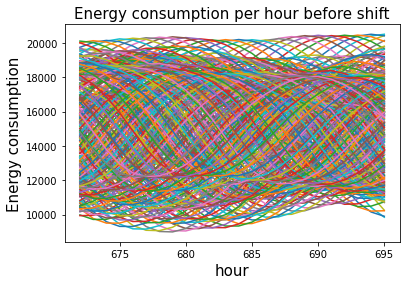

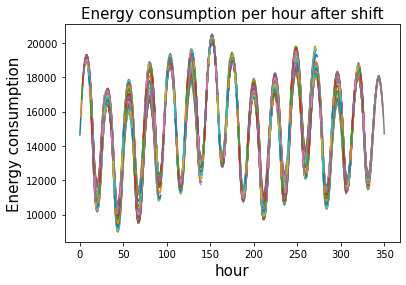

In [62]:
# list of 4 hours prediction into 1 df
hourly_predictions = pd.DataFrame.from_records(predictions)
hourly_predictions = hourly_predictions.transpose()
hourly_predictions.shape
# before shift
#p1 = plt.figure(figsize=(50,40));
p1 = hourly_predictions.plot(legend=False)
plt.title('Energy consumption per hour before shift', fontsize=15)
plt.ylabel('Energy consumption', fontsize=15);
plt.xlabel('hour', fontsize=15);
# add rows to shift data
hourly_predictions = hourly_predictions.reindex(hourly_predictions.index.tolist() + list(range(1, hourly_predictions.shape[1])))
# shift prediction at every hour
for i in range(hourly_predictions.shape[1]):
  hourly_predictions.iloc[:,i] = hourly_predictions.iloc[:,i].shift(periods=i)
del i

hourly_predictions = hourly_predictions.reset_index(drop=True)
hourly_predictions.shape

# after shift
#p1 = plt.figure(figsize=(50,40));
p1 = hourly_predictions.plot(legend=False)
plt.title('Energy consumption per hour after shift', fontsize=15)
plt.ylabel('Energy consumption', fontsize=15);
plt.xlabel('hour', fontsize=15);

#test['time'] = future.tail(test.shape[1])
#test = test.set_index('time')

In [0]:
hourly_predictions_red = hourly_predictions.reset_index(drop=True).head(len(test))
#hourly_predictions_red.tail()
#hourly_predictions_red.shape
test_ds = test.reset_index(drop=True)
#test_ds.tail()
#test_ds.shape
hourly_predictions_red['time'] = test_ds['ds']
hourly_predictions_red = hourly_predictions_red.set_index('time')
test_ds = test_ds.set_index('ds')

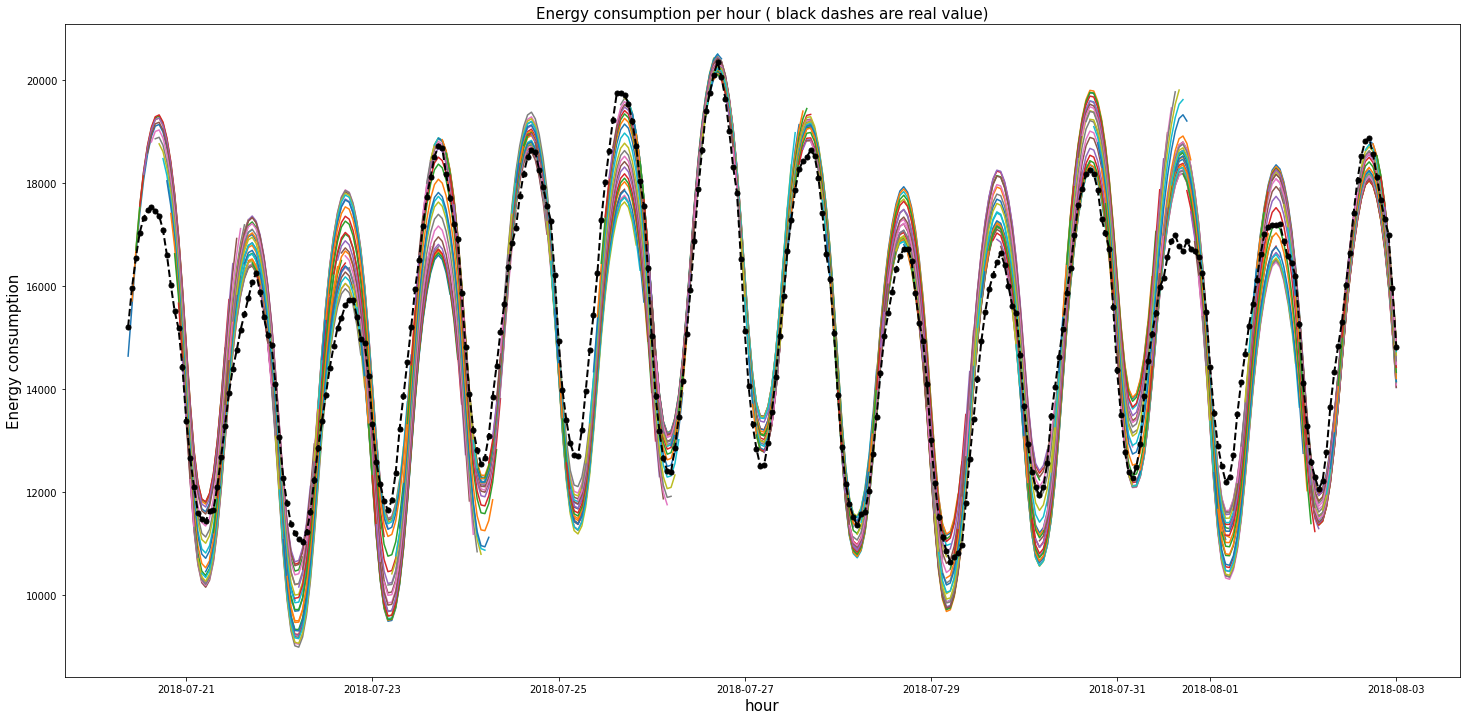

In [64]:
#p1 = plt.figure(figsize=(50,40));
#hourly_predictions_ds.plot(legend=False)
plt.plot(hourly_predictions_red)
plt.plot(test_ds['y'], color='black', marker='o', linestyle='dashed',linewidth=2, markersize=5,label='Real Data')
#test['y'].plot()
plt.gcf().set_size_inches([25,12])
plt.title('Energy consumption per hour ( black dashes are real value)', fontsize=15)
plt.ylabel('Energy consumption', fontsize=15);
plt.xlabel('hour', fontsize=15);

,y,date,day_cost,predictions_eod
ds,,,,
2018-07-20 09:00:00,15210.0,2018-07-20,367980.0,385299.0
2018-07-20 10:00:00,15964.0,2018-07-20,367980.0,387563.0
2018-07-20 11:00:00,16554.0,2018-07-20,367980.0,388285.0
2018-07-20 12:00:00,17039.0,2018-07-20,367980.0,388361.0
2018-07-20 13:00:00,17324.0,2018-07-20,367980.0,387139.0
...,...,...,...,...
2018-08-02 20:00:00,17673.0,2018-08-02,376504.0,377062.0
2018-08-02 21:00:00,17303.0,2018-08-02,376504.0,376448.0
2018-08-02 22:00:00,17001.0,2018-08-02,376504.0,376155.0


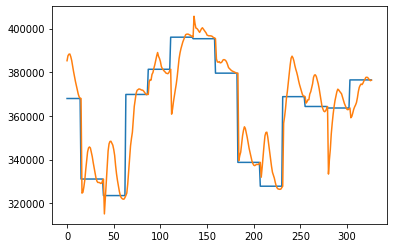

In [65]:
test_eod = test.reset_index(drop=True)
predictions_eod = pd.Series(predictions_eod)
test_eod['predictions_eod']= predictions_eod
test_eod.set_index('ds')
test_eod = test_eod[['day_cost','predictions_eod']]
test_eod = test_eod[:-1]

plt.plot(test_eod['day_cost'])
plt.plot(test_eod['predictions_eod'])